# MPI programs execution time prediction using matrix decomposition algorithm

This notebook introduce MPI programs execution time prediction algorithm base on the matrix decomposition in particular Alternating Least Square algorithm.

Algorithm predicts MPI program execution time on the certain set of computer installation. Computer installation is high-performance computing cluster, data center or supercomputer.

We use data from *spec.org*: MPI benchmarks [https://spec.org/mpi2007/results/mpi2007.html].

Data is constantly updated, so we add it to our repository too.

## Prerequisites
- Go to the directory with data sets
- Create some directories
- Install necessary packages

In [2]:
!ls -la ../data/benchmarks

total 96
drwxrwxr-x 6 andrew andrew  4096 Jul 12 14:55 .
drwxrwxr-x 3 andrew andrew  4096 Jul 12 14:45 ..
drwxrwxr-x 2 andrew andrew 20480 Jul 12 15:06 meta_mpi
drwxrwxr-x 2 andrew andrew 36864 Jul 12 14:43 mpi_logs
drwxrwxr-x 2 andrew andrew  4096 Jul 12 14:45 preprocessed
drwxrwxr-x 2 andrew andrew 20480 Jul 13 16:47 preprocessed_mpi


In [3]:
%cd ../data/benchmarks

/home/andrew/MSU/MC2E/third_stage/publications/Embeddings/code/CloudCom_2020_Embeddings/data/benchmarks


In [4]:
!mkdir ./preprocessed_mpi/
!mkdir ./meta_mpi/

mkdir: cannot create directory ‘./preprocessed_mpi/’: File exists
mkdir: cannot create directory ‘./meta_mpi/’: File exists


In [5]:
!rm ./preprocessed_mpi/*
!pwd

/home/andrew/MSU/MC2E/third_stage/publications/Embeddings/code/CloudCom_2020_Embeddings/data/benchmarks


In [6]:
!python --version

Python 3.6.10 :: Anaconda, Inc.


In [7]:
!conda install pandas numpy matplotlib scikit-learn scipy tqdm -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



## Short introduction

The pipeline is as follows:
- Read data with MPI and OpenMP executions on different computer installation. Each entry in input data is considered as a separate computer installation. Extract execution time for each program on each computer installation;
- Create *PC* matrix (*PC* -- Program-Computer) -- matrix where rows correspond to history of running of programs, columns correspond to the computer installations. In our case one program corresponds to one row in the PC matrix. But you can create *PC* matrix where one program corresponds multiple rows;
- Make prediction using Ridge Regression (as baseline) and ALS algorithm.

## Parse csv with results of programs execution 

In [8]:
import glob
import random
import numpy as np
import pandas as pd

# Read data with MPI benchmarks executions on the different computer installation
for j, i in enumerate(glob.glob('./mpi_logs/*.csv')):
    print(i)
    accel = open(i,'r').readlines()
    f=open('./preprocessed_mpi/'+str(j) + ".csv", 'w')
    f.write("".join(accel[accel.index('"Selected Results Table"\n')+2:accel.index('"Selected Results Table"\n')+16]))
    f.close()
    f=open('./meta_mpi/'+str(j)+".csv", 'w')
    try:
        #f.write("".join(accel[accel.index('HARDWARE\n'):accel.index('"General Notes"\n')]))
        f.write("".join(accel[accel.index('HARDWARE\n'):accel.index('"Node Description: NFS"\n')]))
    except:
        f.write("".join(accel[accel.index('HARDWARE\n'):]))
    f.close()

logs =[]
for i in glob.glob('./preprocessed_mpi/*'):
    logs.append(pd.read_csv(i))

./mpi_logs/mpi2007-20181218-00602.csv
./mpi_logs/mpi2007-20120221-00367.csv
./mpi_logs/mpi2007-20140808-00450.csv
./mpi_logs/mpi2007-20090714-00150.csv
./mpi_logs/mpi2007-20130820-00409.csv
./mpi_logs/mpi2007-20150414-00481.csv
./mpi_logs/mpi2007-20190610-00636.csv
./mpi_logs/mpi2007-20090428-00137.csv
./mpi_logs/mpi2007-20190610-00628.csv
./mpi_logs/mpi2007-20120221-00348.csv
./mpi_logs/mpi2007-20100907-00238.csv
./mpi_logs/mpi2007-20090714-00142.csv
./mpi_logs/mpi2007-20120221-00371.csv
./mpi_logs/mpi2007-20100921-00246.csv
./mpi_logs/mpi2007-20120207-00347.csv
./mpi_logs/mpi2007-20080226-00040.csv
./mpi_logs/mpi2007-20090714-00145.csv
./mpi_logs/mpi2007-20150414-00482.csv
./mpi_logs/mpi2007-20130903-00415.csv
./mpi_logs/mpi2007-20140106-00425.csv
./mpi_logs/mpi2007-20140819-00466.csv
./mpi_logs/mpi2007-20100119-00196.csv
./mpi_logs/mpi2007-20110621-00325.csv
./mpi_logs/mpi2007-20200324-00640.csv
./mpi_logs/mpi2007-20081225-00088.csv
./mpi_logs/mpi2007-20100309-00216.csv
./mpi_logs/m

./mpi_logs/mpi2007-20170925-00570.csv
./mpi_logs/mpi2007-20140218-00441.csv
./mpi_logs/mpi2007-20110621-00312.csv
./mpi_logs/mpi2007-20081203-00085.csv
./mpi_logs/mpi2007-20130820-00397.csv
./mpi_logs/mpi2007-20100727-00227.csv
./mpi_logs/mpi2007-20100907-00243.csv
./mpi_logs/mpi2007-20120221-00387.csv
./mpi_logs/mpi2007-20140808-00455.csv
./mpi_logs/mpi2007-20190312-00610.csv
./mpi_logs/mpi2007-20140218-00440.csv
./mpi_logs/mpi2007-20090922-00180.csv
./mpi_logs/mpi2007-20070529-00023.csv
./mpi_logs/mpi2007-20110621-00305.csv
./mpi_logs/mpi2007-20100907-00237.csv
./mpi_logs/mpi2007-20170829-00547.csv
./mpi_logs/mpi2007-20080922-00065.csv
./mpi_logs/mpi2007-20130903-00417.csv
./mpi_logs/mpi2007-20181218-00605.csv
./mpi_logs/mpi2007-20100119-00198.csv
./mpi_logs/mpi2007-20100921-00250.csv
./mpi_logs/mpi2007-20140819-00460.csv
./mpi_logs/mpi2007-20120221-00362.csv
./mpi_logs/mpi2007-20140106-00429.csv
./mpi_logs/mpi2007-20110831-00330.csv
./mpi_logs/mpi2007-20080206-00035.csv
./mpi_logs/m

In [9]:
# Prepare data for PC matrix creation

computers={}
for j,i in enumerate(logs):
    if i['Base Run Time'].iloc[0] =='NC':
        continue
    computers[j]={'Run Time': i['Base Run Time']}
    if i['Benchmark'].iloc[0] == '121.pop2':
        computers[j]['class'] = 1
    else:
        computers[j]['class'] = 2
    #computers[j]=i['Base Ratio']

class_1 = {}
class_2 = {}
for item in computers.items():
    if item[1]['class'] == 1:
        class_1[item[0]]=item[1]['Run Time']
    else:
        if np.isnan(item[1]['Run Time']).any():
            continue
        class_2[item[0]]=item[1]['Run Time']

## Create *PC* matrix

In [10]:
df = pd.DataFrame.from_records(class_2)

In [11]:
df

,1,5,6,7,9,10,13,14,15,16,...,567,568,571,572,573,574,576,577,578,579
0,371.685835,473.320781,72.394681,105.805730,22.451001,98.644636,200.439129,642.503790,138.408304,291.710527,...,700.450441,77.993420,195.099621,37.015933,49.969667,94.267536,69.741274,521.405322,299.379583,20.551419
1,655.758729,1655.736209,238.169436,384.592714,87.169563,308.340003,628.265758,783.136883,346.280673,668.059706,...,2752.439729,198.710780,522.315083,129.692896,141.973919,262.695832,175.074419,1310.447833,1239.289179,78.573564
2,610.581702,1416.842258,222.455876,276.803203,375.052510,245.781611,451.371561,1039.125776,316.880947,519.744656,...,2048.784982,174.589395,378.621575,595.676356,343.708446,219.393237,157.927308,1532.753560,736.051366,346.043410
3,299.035648,656.979511,115.217125,159.649388,33.651591,143.386136,263.360703,779.138516,188.778525,218.402510,...,1251.507416,92.475809,171.599950,35.352488,68.164113,85.222701,73.802459,539.813014,396.981143,17.198605
4,711.024917,988.953733,249.130315,360.276378,135.070712,244.965720,432.795571,1119.874850,169.904947,431.473430,...,1564.977218,155.843740,348.962574,234.050970,176.070527,299.899224,117.820777,752.622984,622.090732,155.609302
5,897.348835,1432.736532,191.284300,360.437660,53.758398,177.304130,454.682011,1932.297376,169.368559,209.693742,...,1834.400077,127.335557,174.250727,82.605261,105.393508,125.451582,81.948381,943.384674,582.088413,41.150553
6,451.531209,1272.434239,164.329496,296.893979,146.693470,184.317128,414.915084,1710.567779,214.376446,266.319569,...,1748.201391,148.280404,228.462184,225.665622,154.375417,157.313124,106.581402,1036.390153,499.750078,138.269416
7,877.594549,1339.119094,188.516449,364.872744,80.734706,274.078201,563.328335,1192.297332,305.446546,458.517891,...,2155.550356,168.193930,361.122486,124.826211,120.220096,206.569093,137.115130,1170.634225,883.548321,61.501768
8,228.651650,583.864851,82.545693,139.818139,28.681536,106.564245,232.753883,618.629523,101.585243,223.974026,...,998.832703,65.454085,185.100061,44.893200,47.705121,83.972103,45.928531,453.712391,274.694363,23.892556
9,762.461641,1054.887075,171.016799,276.269952,56.535404,165.016914,420.900386,1092.229597,190.932408,238.209719,...,1545.730795,132.671938,191.105873,90.597040,96.953561,140.732926,90.980030,787.300462,515.790876,55.867164


## Matrix decomposition with ALS algorithm

In [12]:
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [20, 10]
def runALS(A, R, n_factors, n_iterations, lambda_):
    n, m = A.shape
    W = 3 * np.random.rand(n, n_factors)
    H = 3 * np.random.rand(n_factors, m)
    A_copy = A
    A = A*R
#     def get_error(A, W, H, R):
#         return ((np.invert(R) * np.abs(A_copy - np.dot(W, H))) / A_copy)# / np.sum(np.invert(R))

    def get_error(A, W, H, R):
        return np.sum((np.invert(R) * np.abs(A_copy - np.dot(W, H))) / A_copy) /np.sum(np.invert(R))
    
    MSE_List = []
    for iter in range(n_iterations):
        for i, Ri in enumerate(R):
            W[i] = np.linalg.solve(np.dot(H, np.dot(np.diag(Ri), H.T)) + lambda_ * np.eye(n_factors),
                                       np.dot(H, np.dot(np.diag(Ri), A[i].T))).T
        #print("Error after solving for W Matrix:", get_error(A, W, H, R))

        for j, Rj in enumerate(R.T):
            H[:,j] = np.linalg.solve(np.dot(W.T, np.dot(np.diag(Rj), W)) + lambda_ * np.eye(n_factors),
                                     np.dot(W.T, np.dot(np.diag(Rj), A[:, j])))
        #print("Error after solving for H Matrix:", get_error(A, W, H, R))

        MSE_List.append(get_error(A, W, H, R))
        #print(f'{iter}th iteration is complete...')

    #print(MSE_List)
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(range(1, len(MSE_List) + 1), MSE_List)
    plt.ylabel('Error')
    plt.xlabel('Iteration')
    plt.show()
    '''
    return W, H, MSE_List[-1]

In [13]:
# Function for zeroing a random entry of PC matrix
def nul_2(df_2, cells, i=-1, j = -1):
    
    if i<0:
        i = random.choice(range(df_2.shape[0]))
    if j<0:
        j = random.choice(range(df_2.shape[1]))
    
    df_2[i, j] = 0
    return df_2, i, j 

## Test ALS decomposition

In [14]:
A = df.to_numpy()
R = np.invert(np.zeros(A.shape, dtype=np.bool))
cells =[]
for i in range(2000):
    R,k,l = nul_2(R, cells)
W,H,loss = runALS(A,R, n_factors=1, n_iterations=2, lambda_=0.3)

In [15]:
R

array([[ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ..., False, False,  True],
       [ True, False,  True, ..., False,  True, False],
       ...,
       [False,  True,  True, ...,  True, False, False],
       [False,  True, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [16]:
np.sum(np.invert(R))/A.shape[0]/A.shape[1]

0.3243978243978244

In [17]:
W,H,loss = runALS(A,R, n_factors=1, n_iterations=2, lambda_=0.3)
W, H, loss

(array([[122.5981695 ],
        [374.72692494],
        [292.95866289],
        [155.51174672],
        [199.34481674],
        [199.26371487],
        [214.02049866],
        [294.56554277],
        [127.53812303],
        [173.40247648],
        [216.95824263],
        [193.03155185],
        [297.23715767]]),
 array([[ 2.34000949,  4.72438145,  0.70912466,  1.37299409,  0.42715101,
          0.84807115,  1.8142893 ,  3.69583236,  0.91193044,  1.65362923,
          0.55190901,  1.30484968,  0.93427315,  4.58972418,  2.28718671,
          0.48329576,  0.65767499,  0.62710701,  0.30956907,  5.3879569 ,
          2.48261807,  1.51305303,  0.81053913,  0.7564993 ,  0.43083833,
          0.38841296,  1.30456258,  4.30134257,  1.04811245,  3.87444101,
          0.62544219,  0.68257359,  0.89458298,  0.49854824,  2.49520282,
          0.64174334,  0.19232404,  1.92400638,  2.78077802,  3.35148312,
          2.30942886,  2.3143205 ,  0.90673284,  3.26359942,  0.45876072,
          0.93166809

## Some useful functions

In [18]:
def gen_X(df_2, cell):
    train = []
    df_np = df_2
    for i in range(df.shape[0]):
        if i != cell[0]:
            train.append(np.concatenate([df_np[i][:cell[1]], df_np[i][cell[1]+1:]]))
    return np.array(train)
    
def gen_Y(df_2, cell): 
    df_np = df_2
    return np.concatenate([df_np[:cell[0],cell[1]], df_np[cell[0]+1:,cell[1]]])
    
    
def gen_predict(df_2, cell):
    df_np = df_2
    return [np.concatenate([df_np[cell[0]][:cell[1]], df_np[cell[0]][cell[1]+1:]])]

## Make prediction using Ridge Regression and ALS decomposition with K=1,2,3,4

In [19]:
from tqdm import tqdm
from sklearn.linear_model import Ridge

A = df.to_numpy()
l_ = []
l__ =[]
points = range(1,400,5)
for point in tqdm(points):
    losses=[]
    ridge_losses =[]
    R = np.invert(np.zeros(A.shape, dtype=np.bool))    
    cells = []
    point = int(A.shape[0]*A.shape[1]*point/100)
    for i in range(point):
        R,k,l = nul_2(R, cells)
        cells.append((k,l))
    df_np = A*R
    diff=[]
    for cell in cells:
        z = Ridge()

        z.fit(gen_X(df_np, cell), gen_Y(df_np, cell))
        y = z.predict(gen_predict(df_np, cell))
        diff.append(np.abs(y - A[cell[0],cell[1]]) / A[cell[0],cell[1]])
    ridge_losses.append(np.mean(diff))
    for n_factors in range(1,5):   
        W_, H_, loss = runALS(A, R, n_factors = n_factors, n_iterations = 2, lambda_ = .3)
        losses.append(loss)
    l_.append([np.sum(100*np.invert(R))/(A.shape[0]*A.shape[1]), losses,ridge_losses])

100%|██████████| 80/80 [08:00<00:00,  6.01s/it]


## Prediction error for algorithms

In [20]:
ALS_losses = [[] for i in range(4)]
percents = []
ridge_losses = []
for i,k in enumerate(points):
    for j in range(4):
        ALS_losses[j].append(l_[i][1][j])
    percents.append(l_[i][0])
    ridge_losses.append(l_[i][2])

for i, e in enumerate(percents):
    print("%d -> %f" % (i, e))

0 -> 0.971251
1 -> 5.885781
2 -> 10.334110
3 -> 14.529915
4 -> 19.114219
5 -> 22.494172
6 -> 26.418026
7 -> 30.380730
8 -> 33.041958
9 -> 36.946387
10 -> 39.976690
11 -> 43.220668
12 -> 45.668221
13 -> 47.863248
14 -> 49.728050
15 -> 53.515929
16 -> 55.361305
17 -> 57.614608
18 -> 58.993784
19 -> 61.674437
20 -> 64.102564
21 -> 65.520591
22 -> 66.996892
23 -> 68.337218
24 -> 69.755245
25 -> 72.086247
26 -> 72.707848
27 -> 73.543124
28 -> 75.252525
29 -> 76.825952
30 -> 77.369852
31 -> 79.972805
32 -> 80.808081
33 -> 81.313131
34 -> 81.779332
35 -> 83.585859
36 -> 83.838384
37 -> 84.595960
38 -> 85.023310
39 -> 85.392385
40 -> 86.013986
41 -> 86.965812
42 -> 87.995338
43 -> 88.403263
44 -> 89.257964
45 -> 89.646465
46 -> 89.918415
47 -> 90.520591
48 -> 90.986791
49 -> 91.064491
50 -> 92.346542
51 -> 92.229992
52 -> 93.084693
53 -> 93.550894
54 -> 93.453768
55 -> 94.017094
56 -> 93.492618
57 -> 94.599845
58 -> 94.619270
59 -> 94.930070
60 -> 95.376845
61 -> 95.668221
62 -> 95.143745
63 -

## Graphics

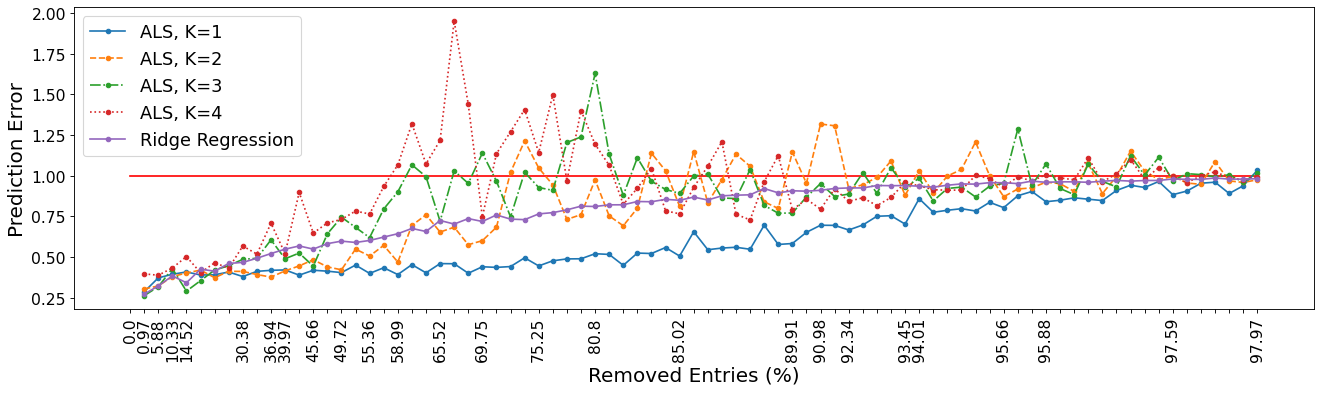

In [21]:
import math

fig = plt.figure(num=None, figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)

plt.plot(range(0, len(ridge_losses) + 1), [1 for i in range(0, len(ridge_losses) + 1)], color="red")

plt.plot(range(1, len(ridge_losses) + 1), list(map(np.mean, ALS_losses[0])), linestyle='-', marker='o', markersize=4, label='ALS, K=1')
plt.plot(range(1, len(ridge_losses) + 1), list(map(np.mean, ALS_losses[1])), linestyle='--', marker='o', markersize=4, label='ALS, K=2')
plt.plot(range(1, len(ridge_losses) + 1), list(map(np.mean, ALS_losses[2])), linestyle='-.', marker='o', markersize=4, label='ALS, K=3')
plt.plot(range(1, len(ridge_losses) + 1), list(map(np.mean, ALS_losses[3])), linestyle=':', marker='o', markersize=4, label='ALS, K=4')
plt.plot(range(1, len(ridge_losses) + 1), ridge_losses, marker='o', linestyle='-', markersize=4, label='Ridge Regression')

# Custom ticks, miss some values
# xticks = [math.ceil(p) for p in percents]
xticks = [int(p * 100) / 100.0 for p in percents]

# Leave 1%, 5%, 10%, 15%, 20%, 25%, 30%, 35%, 40%, 45%, 50%, 55%, 60%, 65%, 70%, 75%, 80%, 85%, 90-98%
miss_index = set(range(0, 80)) - set([0, 1, 2, 3, 7, 9, 10, 12, 14, 16, 18, 21, 24, 28, 32, 38, 46, 48, 50, 54, 55, 61, 64, 73, 79])
for i in miss_index:
    xticks[i] = None

xticks.insert(0, 0.0)

plt.xticks(range(0,len(points)+1), xticks, rotation=90, fontsize=14)
plt.yticks(fontsize=14)

plt.legend(prop={"size": 16})
# plt.title('Dependence of the prediction error on the percentage of removed matrix entries', fontsize=20)
plt.ylabel('Prediction Error', fontsize=18)
plt.xlabel('Removed Entries (%)', fontsize=18)
plt.show()

In [22]:
# PC matrix rank
np.linalg.matrix_rank(W*H, tol=0.01)

1